In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/ucf101-videos")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ucf101-videos


### 1. Import module

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import io
import torch.nn as nn
import os
import pandas as pd
import cv2
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torchvision import transforms
import gc

### Load the dataset

In [2]:
def load_video(path, max_frame=100, size=(480,480)):
    capture = cv2.VideoCapture(path)
    all_frames = []
    while True:
        ret, frame = capture.read()
        if len(all_frames) == max_frame:
            break
        if not ret:
            break
        frame = get_center_square(frame)
        frame = cv2.resize(frame,size)
        frame = frame[:, :, [2,1,0]] # ảnh đọc ra bởi cv2 ở dạng BGR, chuyển về RGB
        frame = torch.tensor(frame)
        frame = frame.permute(2,0,1) # chuyển về channel, height, width
        all_frames.append(frame)
    capture.release()
    return torch.stack(all_frames, dim=0) # dim = (100, 3, size[0], size[1])


"""Get center square of frame"""
def get_center_square(frame):
    y, x = frame.shape[0:2]
    min_lenght = min(x,y)
    start_x = (x//2) - min_lenght//2
    start_y = (y//2) - min_lenght//2
    frame = frame[start_y : start_y + min_lenght, start_x : start_x + min_lenght]
    return frame

In [3]:
folder_path_train = "/kaggle/input/ucf101-videos/train/"
folder_path_test = "/kaggle/input/ucf101-videos/test/"

train_df = pd.read_csv("/kaggle/input/ucf101-videos/train.csv")
test_df = pd.read_csv("/kaggle/input/ucf101-videos/test.csv")

In [4]:
print(train_df['tag'].value_counts())
print(test_df['tag'].value_counts())

tag
Punch           121
PlayingCello    120
CricketShot     118
ShavingBeard    118
TennisSwing     117
Name: count, dtype: int64
tag
CricketShot     49
TennisSwing     49
PlayingCello    44
ShavingBeard    43
Punch           39
Name: count, dtype: int64


#### Create dataframe

In [5]:
def create_dataframe_metadata(df, start, end, label_encoder=None, encode_label=None):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_punch[start:end], df_playCello[start:end], df_CricketShot[start:end], df_ShavingBeard[start:end], df_TennisSwing[start:end]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    if label_encoder is not None:
        new_df['tag'] = label_encoder.fit_transform(new_df['tag'])
    else:
        new_df['tag'] = new_df['tag'].map(encode_label)
    return new_df

In [6]:
label_encoder = LabelEncoder()

In [7]:
df_train = create_dataframe_metadata(train_df, 0, 90, label_encoder=label_encoder)
df_train

,video_name,tag,origin_tag
0,v_Punch_g08_c01.avi,2,Punch
1,v_Punch_g08_c02.avi,2,Punch
2,v_Punch_g08_c03.avi,2,Punch
3,v_Punch_g08_c04.avi,2,Punch
4,v_Punch_g08_c05.avi,2,Punch
...,...,...,...
445,v_TennisSwing_g20_c05.avi,4,TennisSwing
446,v_TennisSwing_g20_c06.avi,4,TennisSwing
447,v_TennisSwing_g21_c01.avi,4,TennisSwing
448,v_TennisSwing_g21_c02.avi,4,TennisSwing


In [8]:
decode_label = dict()
for index, row in df_train.iterrows():
    decode_label.update({row['tag']: row['origin_tag']})
encode_label = {v:k for k,v in decode_label.items()}

In [9]:
df_val = create_dataframe_metadata(train_df, 90, 110, encode_label=encode_label)
df_test = create_dataframe_metadata(test_df, 0, 50, encode_label=encode_label)
df_test

,video_name,tag,origin_tag
0,v_Punch_g01_c01.avi,2,Punch
1,v_Punch_g01_c02.avi,2,Punch
2,v_Punch_g01_c03.avi,2,Punch
3,v_Punch_g01_c04.avi,2,Punch
4,v_Punch_g01_c05.avi,2,Punch
...,...,...,...
219,v_TennisSwing_g07_c03.avi,4,TennisSwing
220,v_TennisSwing_g07_c04.avi,4,TennisSwing
221,v_TennisSwing_g07_c05.avi,4,TennisSwing
222,v_TennisSwing_g07_c06.avi,4,TennisSwing


#### Augumentation dataset

In [10]:
def augmentation_picture(frame):
    transform_a_frame = transforms.Compose([
        # transforms.RandomRotation(degrees=(90,90)), # xoay ảnh 90 90
        transforms.GaussianBlur(kernel_size=11, sigma=1), # làm mờ ảnh nhẹ với vùng ảnh là 11x11
        transforms.RandomErasing(scale=(0.01, 0.1), ratio=(1, 1)) # scale là phạm vi tỷ lệ (min, max) cho vùng xóa so với ảnh ban đầu, ratio là tỉ lệ chiều rộng và cao
    ])
    result = transform_a_frame(frame)
    return result

def augmentation_video(frames):
    new_frames = []
    for frame in frames:
        new_frame = augmentation_picture(frame)
        new_frames.append(new_frame)
    return torch.stack(new_frames,dim=0)

#### Create dataset

In [11]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, img_size=(120,120), all_labels=[], is_train=True):
        self.video_paths = video_paths
        self.img_size = img_size
        self.all_labels = all_labels
        self.new_labels = []
        self.is_train = is_train
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.new_labels[index]

    def load_data(self):
        data = []

        for index, path in tqdm(enumerate(self.video_paths)):
            frames = load_video(path, size=self.img_size)
            self.new_labels.append(self.all_labels[index])
            data.append(frames)

            if self.is_train:
                new_frames = augmentation_video(frames)
                data.append(new_frames)
                self.new_labels.append(self.all_labels[index])
        return pad_sequence(data, batch_first=True, padding_value=0)




In [12]:
all_label_train = list(df_train['tag'])
all_label_val = list(df_val['tag'])

In [13]:
train_paths = [os.path.join(folder_path_train, i) for i in df_train['video_name']]
test_paths = [os.path.join(folder_path_test, i) for i in df_test['video_name']]
val_paths = [os.path.join(folder_path_train, i) for i in df_val['video_name']]

In [14]:
load_video(train_paths[10])[0].shape # channel, height, width

torch.Size([3, 480, 480])

100


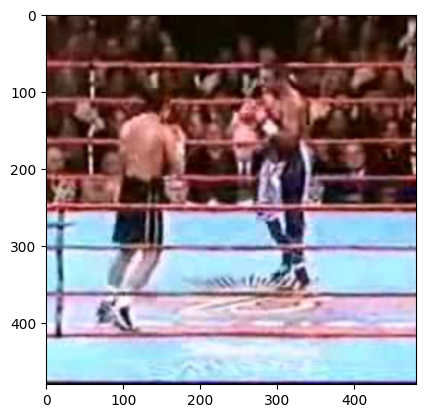

In [15]:
vid0_frame = load_video(val_paths[10])
print(len(vid0_frame))
img_plot_test = vid0_frame[0].permute(1,2,0).numpy() # chuyển về height, width, channel để plot ảnh (224,224,3)
plt.imshow(img_plot_test)

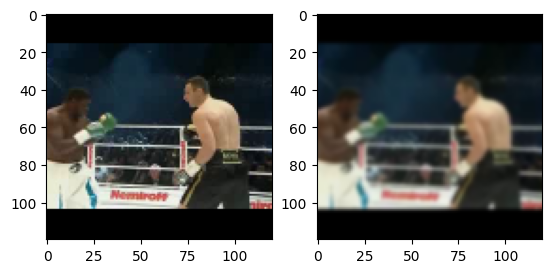

In [16]:
test_augment_path = train_paths[20]
frames_before = load_video(test_augment_path, size=(120,120))
frames_after = augmentation_video(frames_before)

img_after_augment = frames_after[0].permute(1,2,0).numpy()
img_before_augment = frames_before[0].permute(1,2,0).numpy()
fig_aug, ax_aug = plt.subplots(1,2)
ax_aug[0].imshow(img_before_augment)
ax_aug[1].imshow(img_after_augment)

In [17]:
train_dataset = VideoDataset(train_paths, all_labels= all_label_train)
val_dataset = VideoDataset(val_paths, all_labels= all_label_val)
test_dataset = VideoDataset(test_paths, all_labels= list(df_test['tag']), is_train=False)

450it [01:23,  5.41it/s]
100it [00:17,  5.56it/s]
224it [00:10, 22.32it/s]


Punch


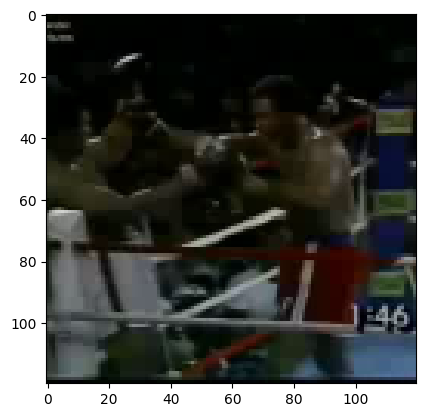

In [18]:
frames, label = train_dataset.__getitem__(100)
print(decode_label[label])
plt.imshow(frames[0].permute(1,2,0).numpy())

In [19]:
# import pickle

# def save_dataset(dataset, path):
#     with open(path, 'wb') as f:
#         pickle.dump(dataset, f)

# def load_dataset(path):
#     with open(path, 'rb') as f:
#         data = pickle.load(f)
#     return data

In [20]:
# save_dataset(train_dataset, "./dataset/train_dataset.pickle")
# save_dataset(val_dataset, "./dataset/val_dataset.pickle")
# save_dataset(test_dataset, "./dataset/test_dataset.pickle")

In [21]:
# train_dataset = load_dataset("./dataset/train_dataset.pickle")
# val_dataset = load_dataset("./dataset/val_dataset.pickle")
# test_dataset = load_dataset("./dataset/test_dataset.pickle")

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Model

In [23]:
def get_cnn_pretrained(model:str = 'resnet50' or 'resnet101' or 'resnet152'):
    if model=='resnet50':
      CNN_pretrained = torchvision.models.resnet50(pretrained = True)
    elif model=='resnet101':
      CNN_pretrained = torchvision.models.resnet101(pretrained = True)
    else:
      CNN_pretrained = torchvision.models.resnet152(pretrained = True)
    CNN_pretrained = torch.nn.Sequential(*list(CNN_pretrained.children())[:8])
    return CNN_pretrained

In [24]:
sample_frames, sample_label = next(iter(val_dataloader))
print(decode_label[int(sample_label[0])])
sample_frames.shape

TennisSwing


torch.Size([8, 100, 3, 120, 120])

In [25]:
Resnet50 = get_cnn_pretrained('resnet50')
Resnet101 = get_cnn_pretrained('resnet101')
Resnet152 = get_cnn_pretrained('resnet152')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [26]:
output_test = Resnet50(sample_frames[:,1].float())
output_test.shape

torch.Size([8, 2048, 4, 4])

In [27]:
output_test = Resnet101(sample_frames[:,1].float())
output_test.shape

torch.Size([8, 2048, 4, 4])

#### CNN-RNN Model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [29]:
class LSTM(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(LSTM, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            hidden = torch.zeros((self.batch_size, self.hidden_size))
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.lstm(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res[0])

        return x

In [31]:
class RNN(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(RNN, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.rnn = nn.RNN(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.rnn(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res)

        return x

In [32]:
# Thêm patience và delta vào EarlyStopping
class EarlyStopping:
    def __init__(self, path_to_save, delta = 0.01, patience = 3, restore_best_weights=True):
        '''
        delta là tham số kiểm soát độ dao động của loss, loss ở các epoch đầu được phép dao dộng lớn hơn loss ở các epoch về sau
        patience là số lượng epoch mà loss không giảm thì sẽ dừng train
        restore_best_weights là lựa chọn có restore lại weight tốt nhất hay không
        '''
        self.best_val_loss_average = np.inf
        self.best_val_loss = np.inf
        self.path_to_save = path_to_save
        self.early_stop = False
        self.delta = delta
        self.patience = patience
        self.counter = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def __call__(self, current_average_loss_val, current_loss_val,model):
        if current_average_loss_val < self.best_val_loss_average:
            print(f"loss validation average decrease from {self.best_val_loss_average} to {current_average_loss_val}, Saving checkpoint...")
            self.best_val_loss_average = current_average_loss_val
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_loss_val < self.best_val_loss:
            print(f"loss validation decrease from {self.best_val_loss} to {current_loss_val}, Saving checkpoint...")
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_average_loss_val < self.best_val_loss_average + self.delta*self.best_val_loss_average:
            print(f"loss validation average slightly increased from {self.best_val_loss_average} to {current_average_loss_val}, No save! ")
            self.counter += 1
        else:
            self.counter += 1
            print(f"No improvement. Early stopping counter: {self.counter}/{self.patience}")
        
        # Nếu counter >= patience thì dừng train
        if self.counter >= self.patience:
            print("Early stopping")
            self.early_stop = True
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
                print("Restore best weights")

### Train & Test

In [42]:
# Thêm path_to_save ở hàm train để lưu checkpoint
class Trainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
        self.history_average_train_loss = []
        self.history_average_train_acc = []
        self.history_average_val_loss = []
        self.history_average_val_acc = []
        self.history_train_acc = []
        self.epoch_after_early_stop = 1
        self.early_stop_epoch = 0
    def val(self, model_val, device):
        torch.cuda.empty_cache()
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        all_loss_vall_current = []
        all_acc_vall_current = []
        last_loss_val = np.inf
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            out = out.to(device)
            criterion_val = self.criterion
            loss_val = criterion_val(out, b)
            all_loss_vall_current.append(loss_val.cpu().detach().numpy())
            total_correct_val += (torch.argmax(out, dim=1) == b).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            all_acc_vall_current.append(acc_val)
            last_loss_val = loss_val
            pbar_val.set_description(f'Acc_val: {acc_val} loss_val {loss_val}')
        loss_val_average = np.average(all_loss_vall_current)
        self.history_average_val_loss.append(loss_val_average)
        self.history_average_val_acc.append(np.average(all_acc_vall_current))
        return loss_val_average, last_loss_val

    def train(self, path_to_save):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        early_stopping = EarlyStopping( path_to_save, delta=0.1)
        index_after_early_stop = 0
        for epoch in range(self.epochs):
            model.train()
            current_loss_train = []
            current_acc_train = []
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            print(optimizer.param_groups[0]['lr'])
            for X, y in pbar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                total_correct += (torch.argmax(yh, dim=1) == y).sum().item()
                total += y.size(0)
                acc = total_correct/total
                loss = criterion(yh, y)
                '''
                Với criterion là CrossEntropyLoss thì thứ tự là output trc rồi đến target
                    vì hàm này yêu cầu chiều của output là (batch_size x class) còn chiều của target là (batch_size)
                '''
                current_loss_train.append(loss.item())
                current_acc_train.append(acc)
                self.history_train_acc.append(acc)
                loss.backward()
                optimizer.step()
                pbar.set_description(f'Epoch: {epoch} Loss: {loss.item()}, Acc: {acc}')
            self.history_average_train_loss.append(np.average(current_loss_train))
            self.history_average_train_acc.append(np.average(current_acc_train))
            current_average_loss_val, current_loss_val = self.val(model.eval(), device)
            print(f"Average loss val: {current_average_loss_val}")
            if early_stopping.early_stop:
                index_after_early_stop += 1
                print(f"epoch {index_after_early_stop} after early stop")
                if index_after_early_stop == self.epoch_after_early_stop:
                    break
                continue
            early_stopping.delta = 1 * (1/(epoch+1)) # điều chỉnh tham số delta theo epoch
            early_stopping(current_average_loss_val, current_loss_val ,model)
            if early_stopping.early_stop:
                print("\n early stop")
                self.early_stop_epoch = epoch


In [34]:
HIDDEN_SIZE = 512
NUM_CLASSES = 5
BATCH_SIZE = 32

In [43]:
# model = LSTM(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE) # thay đổi batch_size nhớ thay cả ở chỗ này
model_resnet50 = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet101 = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet152 = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)

In [44]:
test_output = model_resnet50(sample_frames.to(device))
test_output

tensor([[-0.1818,  0.0147,  0.0330,  0.1602, -0.5681],
        [-0.3997, -0.0580, -0.1176, -0.4679, -0.7549],
        [-0.0352,  0.2720,  0.3690, -0.3971, -0.0276],
        [ 0.0071,  0.1509, -0.1757, -0.2798, -0.1468],
        [-0.1627, -0.1591,  0.2241, -0.3336, -0.5112],
        [ 0.0467,  0.0662,  0.0660, -0.1526, -0.4894],
        [-0.1042, -0.0208, -0.1582, -0.0919, -0.1441],
        [ 0.3597,  0.1913,  0.2413, -0.1243, -0.0332]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [45]:
def get_trainer(model):
    optimizer = torch.optim.AdamW(model.parameters())
    learning_rate = 1e-4
    criterion = nn.CrossEntropyLoss()
    
    n_epochs = 100
    
    return Trainer(train_dataloader, val_dataloader, model, optimizer, criterion, n_epochs)

In [46]:
trainer_resnet50 = get_trainer(model_resnet50)
trainer_resnet101 = get_trainer(model_resnet101)
trainer_resnet152 = get_trainer(model_resnet152)

In [47]:
torch.cuda.empty_cache()
trainer_resnet50.train("model50-rnn_checkpoint.pt")

  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 0 Loss: 1.6862684488296509, Acc: 0.39111111111111113: 100%|██████████| 113/113 [02:11<00:00,  1.16s/it]
Acc_val: 0.36 loss_val 0.7828015685081482: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 1.4073563814163208
loss validation average decrease from inf to 1.4073563814163208, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 1 Loss: 0.9874296188354492, Acc: 0.5333333333333333: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it]
Acc_val: 0.43 loss_val 1.4658362865447998: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 1.372991919517517
loss validation average decrease from 1.4073563814163208 to 1.372991919517517, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 2 Loss: 1.8663142919540405, Acc: 0.5655555555555556: 100%|██████████| 113/113 [02:15<00:00,  1.20s/it]
Epoch: 3 Loss: 0.546202540397644, Acc: 0.5211111111111111: 100%|██████████| 113/113 [02:15<00:00,  1.19s/it] 
Acc_val: 0.345 loss_val 1.6826598644256592: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]              


Average loss val: 1.6963551044464111
loss validation average slightly increased from 1.372991919517517 to 1.6963551044464111, No save! 


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 4 Loss: 0.696516215801239, Acc: 0.6677777777777778: 100%|██████████| 113/113 [02:15<00:00,  1.20s/it] 
Acc_val: 0.32 loss_val 1.0823158025741577: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 1.7333128452301025
loss validation decrease from 1.4658362865447998 to 1.0823158025741577, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 5 Loss: 1.4217814207077026, Acc: 0.6711111111111111: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it] 
Acc_val: 0.515 loss_val 0.9598933458328247: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]             


Average loss val: 1.5668376684188843
loss validation decrease from 1.0823158025741577 to 0.9598933458328247, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 6 Loss: 1.3097882270812988, Acc: 0.6944444444444444: 100%|██████████| 113/113 [02:15<00:00,  1.19s/it]
Acc_val: 0.555 loss_val 1.4182016849517822: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]             


Average loss val: 1.2640864849090576
loss validation average decrease from 1.372991919517517 to 1.2640864849090576, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 7 Loss: 0.6761908531188965, Acc: 0.7544444444444445: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it] 
Acc_val: 0.355 loss_val 1.0323874950408936: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]              


Average loss val: 1.4655120372772217
loss validation decrease from 1.4182016849517822 to 1.0323874950408936, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 8 Loss: 1.9166027307510376, Acc: 0.7177777777777777: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it] 
Acc_val: 0.52 loss_val 1.1261829137802124: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 1.425142526626587
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 9 Loss: 1.282018780708313, Acc: 0.6888888888888889: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it] 
Acc_val: 0.46 loss_val 1.4196407794952393: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 1.52773118019104
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Acc_val: 0.505 loss_val 1.4920263290405273: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]             


Average loss val: 1.2523690462112427
loss validation average decrease from 1.2640864849090576 to 1.2523690462112427, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 11 Loss: 0.3306410014629364, Acc: 0.7722222222222223: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it] 
Acc_val: 0.405 loss_val 2.032644033432007: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 2.0517702102661133
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Acc_val: 0.49 loss_val 1.8639140129089355: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]              


Average loss val: 2.1223461627960205
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 13 Loss: 0.9724390506744385, Acc: 0.7011111111111111: 100%|██████████| 113/113 [02:15<00:00,  1.20s/it]
Acc_val: 0.53 loss_val 0.912613570690155: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 1.0856375694274902
loss validation average decrease from 1.2523690462112427 to 1.0856375694274902, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 14 Loss: 0.29227688908576965, Acc: 0.7288888888888889: 100%|██████████| 113/113 [02:15<00:00,  1.20s/it]
Acc_val: 0.53 loss_val 2.1912131309509277: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]              


Average loss val: 2.2296652793884277
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 15 Loss: 1.853946566581726, Acc: 0.6811111111111111: 100%|██████████| 113/113 [02:15<00:00,  1.20s/it]  
Acc_val: 0.46 loss_val 1.2798724174499512: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]               


Average loss val: 2.0118579864501953
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 16 Loss: 0.27217841148376465, Acc: 0.7666666666666667: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it]
Acc_val: 0.575 loss_val 1.325616478919983: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]              


Average loss val: 1.236259937286377
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 17 Loss: 0.2080366015434265, Acc: 0.7766666666666666: 100%|██████████| 113/113 [02:14<00:00,  1.19s/it] 
Acc_val: 0.585 loss_val 1.448881983757019: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]              

Average loss val: 1.4663795232772827
epoch 1 after early stop


In [48]:
torch.cuda.empty_cache()
trainer_resnet101.train('model101-rnn_checkpoint.pt')

  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 0 Loss: 0.8447573184967041, Acc: 0.42777777777777776: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it]
Acc_val: 0.33 loss_val 1.6210731267929077: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]               


Average loss val: 1.536022663116455
loss validation average decrease from inf to 1.536022663116455, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 1 Loss: 1.8514734506607056, Acc: 0.6022222222222222: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it]
Acc_val: 0.33 loss_val 1.8036333322525024: 100%|██████████| 25/25 [00:45<00:00,  1.80s/it]               


Average loss val: 2.051225185394287
loss validation average slightly increased from 1.536022663116455 to 2.051225185394287, No save! 


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 2 Loss: 0.7296323776245117, Acc: 0.6466666666666666: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it]
Acc_val: 0.495 loss_val 0.9315741658210754: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]              


Average loss val: 1.2394328117370605
loss validation average decrease from 1.536022663116455 to 1.2394328117370605, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 3 Loss: 2.397312641143799, Acc: 0.7088888888888889: 100%|██████████| 113/113 [03:49<00:00,  2.03s/it]  
Acc_val: 0.415 loss_val 1.8397310972213745: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]              


Average loss val: 1.3858580589294434
loss validation average slightly increased from 1.2394328117370605 to 1.3858580589294434, No save! 


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 4 Loss: 0.433981716632843, Acc: 0.7422222222222222: 100%|██████████| 113/113 [03:49<00:00,  2.04s/it]  
Acc_val: 0.505 loss_val 0.6788702011108398: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]              


Average loss val: 1.4775317907333374
loss validation decrease from 0.9315741658210754 to 0.6788702011108398, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 5 Loss: 0.8160738348960876, Acc: 0.6522222222222223: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it]
Acc_val: 0.205 loss_val 1.8170918226242065: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]              


Average loss val: 1.965024709701538
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 6 Loss: 0.7850386500358582, Acc: 0.5944444444444444: 100%|██████████| 113/113 [03:49<00:00,  2.03s/it]
Acc_val: 0.445 loss_val 2.168767213821411: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]               


Average loss val: 2.1014535427093506
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 7 Loss: 0.5348131060600281, Acc: 0.7533333333333333: 100%|██████████| 113/113 [03:49<00:00,  2.03s/it]
Acc_val: 0.74 loss_val 0.7131710052490234: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]               


Average loss val: 0.8104531168937683
loss validation average decrease from 1.2394328117370605 to 0.8104531168937683, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 8 Loss: 1.8581371307373047, Acc: 0.7655555555555555: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it] 
Acc_val: 0.55 loss_val 0.8511555790901184: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]              


Average loss val: 1.4144196510314941
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 9 Loss: 0.8569526076316833, Acc: 0.6922222222222222: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it] 
Acc_val: 0.52 loss_val 1.7121729850769043: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]              


Average loss val: 1.4776413440704346
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 10 Loss: 1.000205159187317, Acc: 0.7555555555555555: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it]  
Acc_val: 0.265 loss_val 1.8754935264587402: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]              


Average loss val: 1.660072684288025
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 11 Loss: 0.056438054889440536, Acc: 0.6377777777777778: 100%|██████████| 113/113 [03:50<00:00,  2.04s/it]
Acc_val: 0.5 loss_val 1.7283830642700195: 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]                

Average loss val: 1.3063337802886963
epoch 1 after early stop


In [51]:
torch.cuda.empty_cache()
trainer_resnet152.train('model152-rnn_checkpoint.pt')

  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Acc_val: 0.53 loss_val 1.1662935018539429: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 2.4598424434661865
loss validation average decrease from inf to 2.4598424434661865, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 1 Loss: 0.8681720495223999, Acc: 0.6655555555555556: 100%|██████████| 113/113 [05:21<00:00,  2.84s/it]
Acc_val: 0.33 loss_val 1.9976091384887695: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]               


Average loss val: 1.6686129570007324
loss validation average decrease from 2.4598424434661865 to 1.6686129570007324, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Acc_val: 0.585 loss_val 0.9777316451072693: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]             


Average loss val: 1.0744802951812744
loss validation average decrease from 1.6686129570007324 to 1.0744802951812744, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 3 Loss: 0.12055784463882446, Acc: 0.7788888888888889: 100%|██████████| 113/113 [05:21<00:00,  2.84s/it]
Acc_val: 0.475 loss_val 2.2597732543945312: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 1.6094393730163574
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 4 Loss: 0.46404165029525757, Acc: 0.7922222222222223: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it]
Acc_val: 0.415 loss_val 0.9593160152435303: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 1.1121464967727661
loss validation decrease from 0.9777316451072693 to 0.9593160152435303, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 5 Loss: 0.9310329556465149, Acc: 0.8366666666666667: 100%|██████████| 113/113 [05:22<00:00,  2.86s/it] 
Acc_val: 0.635 loss_val 0.8002234697341919: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]             


Average loss val: 1.0714941024780273
loss validation average decrease from 1.0744802951812744 to 1.0714941024780273, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 6 Loss: 1.2734651565551758, Acc: 0.7944444444444444: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it] 
Acc_val: 0.535 loss_val 2.8015596866607666: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]             


Average loss val: 1.5611517429351807
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 7 Loss: 1.3670551776885986, Acc: 0.7733333333333333: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it] 
Acc_val: 0.5 loss_val 1.2182763814926147: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]                


Average loss val: 1.7463421821594238
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 8 Loss: 0.7138167023658752, Acc: 0.7955555555555556: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it] 
Acc_val: 0.58 loss_val 1.6459136009216309: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]               


Average loss val: 0.835069477558136
loss validation average decrease from 1.0714941024780273 to 0.835069477558136, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 9 Loss: 0.2276272177696228, Acc: 0.7944444444444444: 100%|██████████| 113/113 [05:22<00:00,  2.86s/it] 
Acc_val: 0.575 loss_val 3.0662612915039062: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]             


Average loss val: 1.6880886554718018
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 10 Loss: 1.0674102306365967, Acc: 0.7811111111111111: 100%|██████████| 113/113 [05:22<00:00,  2.86s/it] 
Acc_val: 0.365 loss_val 1.1246941089630127: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 1.7238961458206177
loss validation decrease from 1.6459136009216309 to 1.1246941089630127, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 11 Loss: 0.27256423234939575, Acc: 0.7955555555555556: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it]
Acc_val: 0.53 loss_val 2.1695830821990967: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]              


Average loss val: 1.5368870496749878
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 12 Loss: 0.5250229835510254, Acc: 0.7622222222222222: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it] 
Acc_val: 0.55 loss_val 1.5342333316802979: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 1.308790922164917
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 13 Loss: 0.3807300627231598, Acc: 0.7622222222222222: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it] 
Acc_val: 0.59 loss_val 0.4777485728263855: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 0.9625614881515503
loss validation decrease from 1.1246941089630127 to 0.4777485728263855, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 14 Loss: 0.31324055790901184, Acc: 0.8222222222222222: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it] 
Acc_val: 0.505 loss_val 1.3326297998428345: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 1.8009252548217773
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 15 Loss: 0.706045925617218, Acc: 0.8433333333333334: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it]  
Acc_val: 0.6 loss_val 0.9089213609695435: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]               


Average loss val: 1.1489744186401367
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 16 Loss: 0.48450034856796265, Acc: 0.8577777777777778: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it]
Acc_val: 0.745 loss_val 0.30825749039649963: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]             


Average loss val: 0.6776773929595947
loss validation average decrease from 0.835069477558136 to 0.6776773929595947, Saving checkpoint...


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Acc_val: 0.61 loss_val 0.9472836256027222: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]              


Average loss val: 0.888437032699585
No improvement. Early stopping counter: 1/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Acc_val: 0.495 loss_val 1.2660197019577026: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 2.053452491760254
No improvement. Early stopping counter: 2/3


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 19 Loss: 0.5986539721488953, Acc: 0.8255555555555556: 100%|██████████| 113/113 [05:22<00:00,  2.85s/it] 
Acc_val: 0.54 loss_val 0.4658815264701843: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              


Average loss val: 1.3402931690216064
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/113 [00:00<?, ?it/s]

0.001


Epoch: 20 Loss: 0.5280763506889343, Acc: 0.8188888888888889: 100%|██████████| 113/113 [05:22<00:00,  2.86s/it] 
Acc_val: 0.61 loss_val 0.5222969055175781: 100%|██████████| 25/25 [01:03<00:00,  2.55s/it]              

Average loss val: 0.9796836376190186
epoch 1 after early stop


In [52]:
trainer_resnet50.history_average_val_loss

[1.4073564,
 1.3729919,
 1.5775687,
 1.6963551,
 1.7333128,
 1.5668377,
 1.2640865,
 1.465512,
 1.4251425,
 1.5277312,
 1.252369,
 2.0517702,
 2.1223462,
 1.0856376,
 2.2296653,
 2.011858,
 1.2362599,
 1.4663795]

In [53]:
import matplotlib.pyplot as plt

def get_plot(trainer, type, model_name):
    plt.title(model_name)
    
    if type == 'loss':
        plt.plot(trainer.history_average_train_loss, label='train loss')
        plt.plot(trainer.history_average_val_loss, label='val loss')
    else:
        plt.plot(trainer.history_average_train_acc, label='train acc')
        plt.plot(trainer.history_average_val_acc, label='val acc')
    plt.axvline(trainer.early_stop_epoch - 3, color='r', linestyle='--', label='early stop')
    plt.legend()
    plt.show()

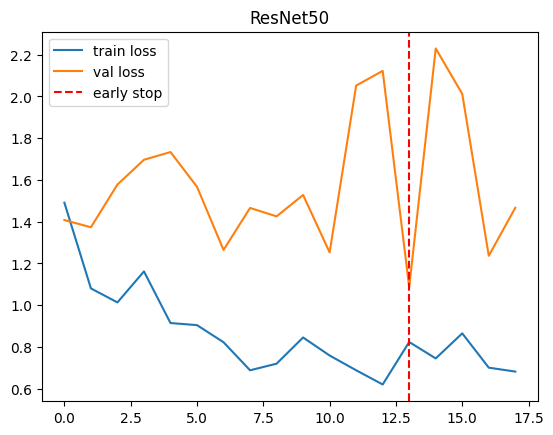

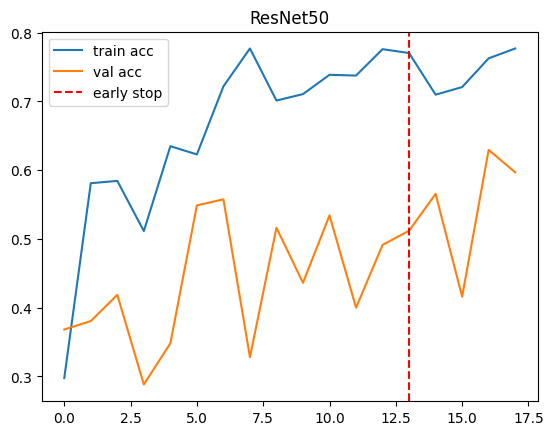

In [54]:
get_plot(trainer_resnet50, "loss", "ResNet50")
get_plot(trainer_resnet50, "acc", "ResNet50")

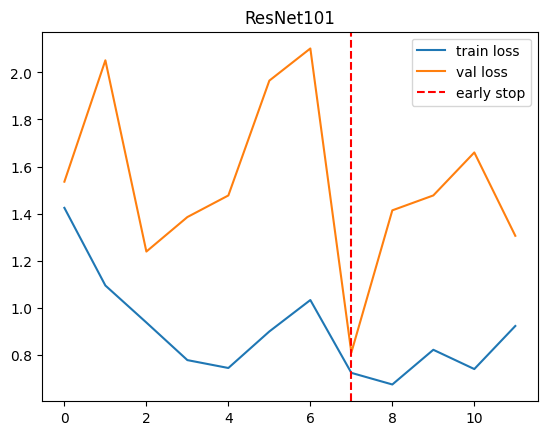

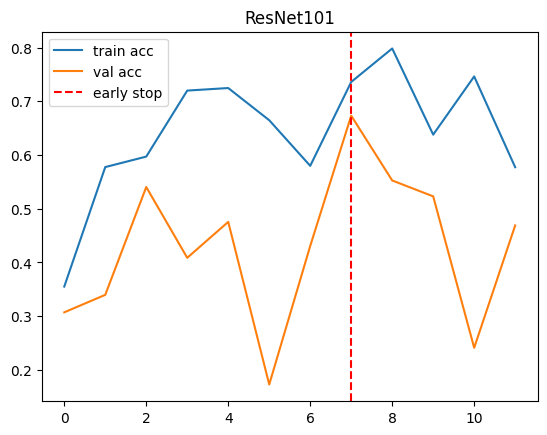

In [55]:
get_plot(trainer_resnet101, "loss", "ResNet101")
get_plot(trainer_resnet101, "acc", "ResNet101")

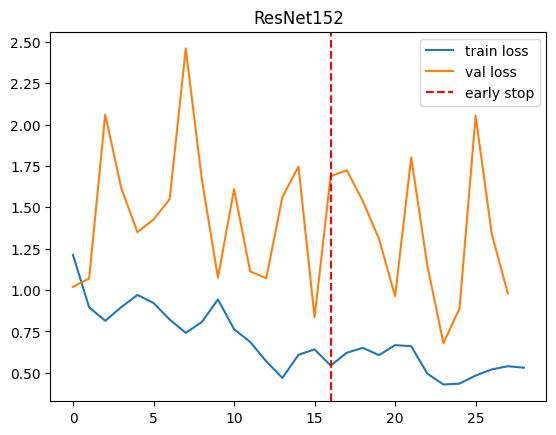

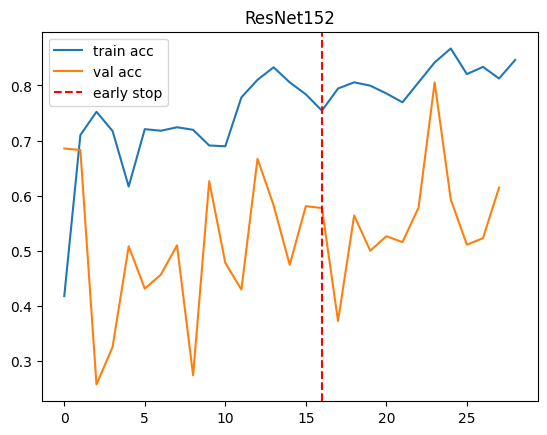

In [56]:
get_plot(trainer_resnet152, "loss", "ResNet152")
get_plot(trainer_resnet152, "acc", "ResNet152")

### Test

In [57]:
class Tester:
    def __init__(self, model, dataloader_test):
        self.dataloader_test = dataloader_test
        self.model = model
    def test(self):
        torch.cuda.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_test = self.model
        model_test.to(device)
        pbar_test = tqdm(self.dataloader_test)
        total_test = 0
        total_correct_test = 0
        for a, b in pbar_test:
            a = a.to(device)
            b = b.to(device)
            out = model_test(a)
            total_correct_test += (torch.argmax(out, dim=1) == b).sum().item()
            total_test += b.size(0)
            acc_test = total_correct_test/total_test
            pbar_test.set_description(f'Acc_test: {acc_test}')

In [58]:
model_resnet50_save = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet50_save.load_state_dict(torch.load("./model50-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [59]:
test_resnet50 = Tester(model_resnet50_save, test_dataloader)
test_resnet50.test()

Acc_test: 0.5580357142857143: 100%|██████████| 28/28 [00:28<00:00,  1.03s/it]


In [60]:
model_resnet101_save = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet101_save.load_state_dict(torch.load("./model101-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [61]:
test_resnet101 = Tester(model_resnet101_save, test_dataloader)
test_resnet101.test()

Acc_test: 0.6696428571428571: 100%|██████████| 28/28 [00:51<00:00,  1.83s/it]


In [62]:
model_resnet152_save = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet152_save.load_state_dict(torch.load("./model152-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [63]:
test_resnet152 = Tester(model_resnet152_save, test_dataloader)
test_resnet152.test()

Acc_test: 0.625: 100%|██████████| 28/28 [01:11<00:00,  2.55s/it]             
